In [ ]:
#| default_exp data

:::{.callout-tip}

This module can be imported using `from openhsi.data import *`

:::

In [ ]:
#| hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

In [ ]:
#| export

from fastcore.foundation import patch
from fastcore.meta import delegates
from fastcore.basics import listify
from fastcore.xtras import *
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from PIL import Image
from scipy.signal import decimate

from typing import Iterable, Union, Callable, List, TypeVar, Generic, Tuple, Optional
import json
import pickle
from datetime import datetime, timezone, timedelta
import time
from pathlib import Path
import warnings
import pprint

import holoviews as hv
hv.extension("bokeh",logo=False)

In [ ]:
#| export
#| hide

# numpy.ndarray type hints
Shape = TypeVar("Shape"); DType = TypeVar("DType")
class Array(np.ndarray, Generic[Shape, DType]):
    """  
    Use this to type-annotate numpy arrays, e.g. 
        image: Array['H,W,3', np.uint8]
        xy_points: Array['N,2', float]
        nd_mask: Array['...', bool]
    from: https://stackoverflow.com/questions/35673895/type-hinting-annotation-pep-484-for-numpy-ndarray
    """
    pass

## Generic Circular Buffer on `numpy.ndarray`s

The base functionality is implemented on a generic circular buffer. The datatype `dtype` can be modified as desired but the default is set to store `uint16` digital numbers. 

In [ ]:
#| export

class CircArrayBuffer():
    """Circular FIFO Buffer implementation on ndarrays. Each put/get is a (n-1)darray."""
    
    def __init__(self, 
                 size:tuple = (100,100), # Shape of n-dim circular buffer to preallocate
                 axis:int = 0,           # Which axis to traverse when filling the buffer
                 dtype:type = np.uint8,  # Buffer numpy data type
                 show_func:Callable[[np.ndarray],"plot"] = None, # Custom plotting function if desired
                ):
        """Preallocate a array of `size` and type `dtype` and init write/read pointer."""
        self.data = np.zeros(size, dtype=dtype)
        self.size = size
        self.axis = axis
        self.write_pos = [slice(None,None,None) if i != axis else 0 for i in range(len(size)) ]
        self.read_pos  = self.write_pos.copy()
        self.slots_left = self.size[self.axis]
        self.show_func = show_func
        
    def __getitem__(self, key:slice):
        return self.data[key]
    
    def _inc(self, idx:List[slice]) -> List[slice]:
        """Increment read/write index with wrap around"""
        idx[self.axis] += 1
        if idx[self.axis] == self.size[self.axis]:
            idx[self.axis] = 0
        return idx
    
    def is_empty(self) -> bool:
        return self.slots_left == self.size[self.axis]

    def put(self, line:np.ndarray):
        """Writes a (n-1)darray into the buffer"""
        self.data[tuple(self.write_pos)] = line
        
        # if buffer full, update read position to keep track of oldest slot
        self.slots_left -= 1
        if self.slots_left < 0:
            self.slots_left = 0
            self.read_pos = self._inc(self.read_pos)
        
        self.write_pos = self._inc(self.write_pos)
            
    def get(self) -> np.ndarray:
        """Reads the oldest (n-1)darray from the buffer"""
        if self.slots_left < self.size[self.axis]:
            val = self.data[tuple(self.read_pos)]
            self.slots_left += 1
            self.read_pos = self._inc(self.read_pos)
            return val
        else:
            return None

    def show(self):
        """Display the data """
        if self.show_func is None:
            if len(self.size) == 2:
                return hv.Image(self.data.copy(), bounds=(0,0,*self.size)).opts(
                    xlabel="wavelength index",ylabel="cross-track",cmap="gray")
            elif len(self.size) == 3:
                # Sum over the last dimensions (assumed wavelength) and show as monochrome
                return hv.Image(np.sum(self.data,axis=-1), bounds=(0,0,*self.size[:2])).opts(
                    xlabel="along-track",ylabel="cross-track",cmap="gray")
            elif len(self.size) == 1:
                print(f"#({self.size[0]}) {self.data}")
        elif self.show_func is not None:
            return self.show_func(self.data)
        else:
            print("Unsupported array shape. Please use 2D or 3D shapes or use your own custom show function")

In [ ]:
show_doc(CircArrayBuffer.put)

---

[source](https://github.com/openhsi/openhsi/blob/master/openhsi/data.py#L77){target="_blank" style="float:right; font-size:smaller"}

### CircArrayBuffer.put

>      CircArrayBuffer.put (line:numpy.ndarray)

*Writes a (n-1)darray into the buffer*

In [ ]:
show_doc(CircArrayBuffer.get)

---

[source](https://github.com/openhsi/openhsi/blob/master/openhsi/data.py#L89){target="_blank" style="float:right; font-size:smaller"}

### CircArrayBuffer.get

>      CircArrayBuffer.get ()

*Reads the oldest (n-1)darray from the buffer*

In [ ]:
show_doc(CircArrayBuffer.show)

---

[source](https://github.com/openhsi/openhsi/blob/master/openhsi/data.py#L99){target="_blank" style="float:right; font-size:smaller"}

### CircArrayBuffer.show

>      CircArrayBuffer.show ()

*Display the data*

For example, we can write to a 1D array

In [ ]:
cib = CircArrayBuffer(size=(7,),axis=0)
for i in range(9):
    cib.put(i)
    cib.show()

for i in range(9):
    print(i,cib.get())

#(7) [0 0 0 0 0 0 0]
#(7) [0 1 0 0 0 0 0]
#(7) [0 1 2 0 0 0 0]
#(7) [0 1 2 3 0 0 0]
#(7) [0 1 2 3 4 0 0]
#(7) [0 1 2 3 4 5 0]
#(7) [0 1 2 3 4 5 6]
#(7) [7 1 2 3 4 5 6]
#(7) [7 8 2 3 4 5 6]
0 2
1 3
2 4
3 5
4 6
5 7
6 8
7 None
8 None


Or a 2D array

In [ ]:
plots_list = []

cib = CircArrayBuffer(size=(4,4),axis=0)
cib.put(1) # scalars are broadcasted to a 1D array
for i in range(5):
    cib.put(cib.get()+1)
    plots_list.append( cib.show().opts(colorbar=True,title=f"i={i}") )

hv.Layout(plots_list).cols(3)

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)
   .Image.IV  :Image   [x,y]   (z)
   .Image.V   :Image   [x,y]   (z)

## Loading Camera Settings and Calibration Files

The OpenHSI camera has a settings dictionary which contains these fields:
- `camera_id` is your camera name,
- `row_slice` indicates which rows are illuminated and we crop out the rest,
- `resolution` is the full pixel resolution given by the camera without cropping, and
- `fwhm_nm` specifies the size of spectral bands in nanometers,
- `exposure_ms` is the camera exposure time last used,
- `luminance` is the reference luminance to convert digital numbers to luminance,
- `longitude` is the longitude degrees east,
- `latitude` is the latitude degrees north,
- `datetime_str` is the UTC time at time of data collection,
- `altitude` is the altitude above sea level (assuming target is at sea level) measured in km,
- `radiosonde_station_num` is the station number from http://weather.uwyo.edu/upperair/sounding.html,
- `radiosonde_region` is the region code from http://weather.uwyo.edu/upperair/sounding.html, and
- `sixs_path` is the path to the 6SV executable.
- `binxy` number of pixels to bin in (x,y) direction
- `win_offset` offsets (x,y) from edge of detector for a selective readout window (used in combination with a `win_resolution` less than full detector size).
- `win_resolution` size of area on detector to readout (width, height)
- `pixel_format` format of pixels readout sensor, ie 8bit, 10bit, 12bit

The settings dictionary may also contain additional camera specific fields:
- `mac_addr` is GigE camera mac address - used by Lucid Vision Sensors
- `serial_num` serial number of detector - used by Ximea and FLIR Sensors


The pickle file is a dictionary with these fields:
- `camera_id` is your camera name,
- `HgAr_pic` is a picture of a mercury argon lamp's spectral lines for wavelength calibration,
- `flat_field_pic` is a picture of a well lit  for calculating the illuminated area,
- `smile_shifts` is an array of pixel shifts needed to correct for smile error,
- `wavelengths_linear` is an array of wavelengths after linear interpolation,
- `wavelengths` is an array of wavelengths after cubic interpolation,
- `rad_ref` is a 4D datacube with coordinates of cross-track, wavelength, exposure, and luminance,
- `sfit` is the spline fit function from the integrating sphere calibration, and
- `rad_fit` is the interpolated function of the expected radiance at sensor computed using 6SV.

These files are unique to each OpenHSI camera. 

In [ ]:
#| export

class CameraProperties():
    """Save and load OpenHSI camera settings and calibration"""
    def __init__(self, 
                 json_path:str = None,  # Path to settings file
                 cal_path:str  = None,  # Path to calibration file
                 print_settings:bool = False, # Print out settings file contents
                 **kwargs):
        """Load the settings and calibration files"""
        self.json_path = json_path
        if 'pkl_path' in kwargs:
            if cal_path is not None:
                raise ValueError("Both 'pkl_path' and 'cal_path' cannot be provided. Please use only 'cal_path'.")
            cal_path = kwargs['pkl_path']
        
        self.cal_path = cal_path
        
        if json_path:
            with open(self.json_path) as json_file:
                self.settings = json.load(json_file)
        else:
            self.settings = {}

        if cal_path:
            file_extension = os.path.splitext(cal_path)[-1].lower()

            if file_extension in ('.pkl', '.pickle'):
                warnings.warn(
                    "Pickle calibration files are deprecated and will be removed in a "
                    "future version. Please convert to .nc format using `.dump()` "
                    "(which now saves to .nc by default).",
                    DeprecationWarning,
                    stacklevel=2
                )
                try:
                    with open(cal_path, 'rb') as handle:
                        self.calibration = pickle.load(handle)
                    self.cal_path = cal_path[:-len(file_extension)]+'.nc'
                    self.save_calibration_data_to_netcdf(self.cal_path)
                    print(f"Updated calibration file saved at {self.cal_path}")
                except (pickle.UnpicklingError, AttributeError, EOFError, ImportError) as e:
                    raise type(e)(
                        f"Failed to load object from {cal_path}: {e}. "
                        "Issue likely due to changes in dependencies since the pickle file "
                        "was saved. Likely issue is xarray not being 2022.3.0. "
                        "Recommended fix is to install this version and convert to the new "
                        "NetCDF-based calibration file using `.dump()`."
                    ) from e

            elif file_extension == '.nc':
                self.load_calibration_data_from_netcdf(cal_path)
            else:
                raise ValueError(f"Unsupported file type: {file_extension}")
        else:
            self.calibration = {}

        # overide any settings from settings file with keywords value pairs.
        for key,value in kwargs.items():
            if key in self.settings.keys(): 
                self.settings[key] = value
                if print_settings:
                    print("Setting File Override: {0} = {1}".format(key, value))
        if print_settings:
            pprint.pprint(self.settings)
    
    def __repr__(self):
        from pprint import pformat
        return "settings = \n" + pformat(self.settings) + \
               "\n\ncalibration = \n" + pformat(self.calibration)
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        pass

    def dump(self, json_path:str = None, cal_path:str = None, use_pickle:bool = False):
        """Save the settings and calibration files"""
        with open(self.json_path[:-5]+"_updated.json" if json_path is None else json_path, 'w') as outfile:
            json.dump(self.settings, outfile,indent=4,)
            
        if use_pickle: # must provide filename for pickle.
            warnings.warn(
                "Pickle calibration files are deprecated and will be removed in a "
                "future version. We sugesting using the .nc format using `.dump()` "
                "(which now saves to .nc by default).",
                DeprecationWarning,
                stacklevel=2
            )
            with open(cal_path,'wb') as handle:
                pickle.dump(self.calibration,handle,protocol=4)
        else:
            self.save_calibration_data_to_netcdf(self.cal_path[:-3]+"_updated.nc" if cal_path is None else cal_path)

    def save_calibration_data_to_netcdf(self, filename):
        """
        Save the calibration data dictionary to a NetCDF file using xarray. Intended to be more portable then pickle.

        Parameters:
            filename (str): The filename to save to (NetCDF format).
        """

        attrs = {}
        ds_dict = {}

        for key, value in self.calibration.items():
            if isinstance(value, (int, float, str)):  # Handle attributes
                attrs[key] = value
            elif isinstance(value, xr.DataArray):  # Handle DataArrays
                ds_dict[key] = value
            elif isinstance(value, interp1d):  # Handle interp1d objects
                ds_dict[f'{key}_x'] = ((f'{key}_dim'), value.x)
                ds_dict[f'{key}_y'] = ((f'{key}_dim'), value.y)
            elif isinstance(value, np.ndarray):  # Handle numpy arrays
                if value.ndim == 1:
                    ds_dict[key] = ((f'{key}_dim'), value)
                elif value.ndim == 2:
                    ds_dict[key] = ((f'{key}_dim_x', f'{key}_dim_y'), value)
                else:
                    raise ValueError(f"Unsupported numpy array dimension: {value.ndim} for key: {key}")
            else:
                raise ValueError(f"Unsupported data type: {type(value)} for key: {key}")

        # Create the xarray.Dataset
        ds = xr.Dataset(ds_dict, attrs=attrs)

        # Save to NetCDF with compression (adjust encoding if needed)
        encoding = {key: {'zlib': True, 'complevel': 4} for key in ds_dict if isinstance(ds_dict[key], xr.DataArray)}
        ds.to_netcdf(filename, mode='w', encoding=encoding)

    def load_calibration_data_from_netcdf(self, filename):
        """
        Load the calibration data dictionary from a NetCDF file using xarray.

        Parameters:
            filename (str): The filename to load from (NetCDF format).

        Returns:
            dict: The loaded calibration data dictionary.
        """

        ds = xr.open_dataset(filename)
        data_dict = {}

        # Load attributes
        data_dict.update(ds.attrs)

        # Load data variables
        for key, value in ds.items():
            if isinstance(value, xr.DataArray):
                if value.ndim == 1:
                    # Check if it's an interp1d object
                    if f'{key[:-5]}fit_y' in ds:  # Check for corresponding _y data
                        data_dict[key[:-2]] = interp1d(
                            ds[f'{key[:-2]}_x'].values,
                            ds[f'{key[:-2]}_y'].values,
                            kind='cubic'
                        )
                    else:  # Otherwise, it's a regular 1D array
                        data_dict[key] = value.values
                elif value.ndim == 2:
                    data_dict[key] = value.values
                else:  # Handle any dimension > 2, assume xarray
                    data_dict[key] = value

        self.calibration=data_dict
        ds.close()


In [ ]:
show_doc(CameraProperties.dump)

---

[source](https://github.com/openhsi/openhsi/blob/master/openhsi/data.py#L192){target="_blank" style="float:right; font-size:smaller"}

### CameraProperties.dump

>      CameraProperties.dump (json_path:str=None, cal_path:str=None,
>                             use_pickle:bool=False)

*Save the settings and calibration files*

For example, the contents of `CameraProperties` consists of two dictionaries. To produce the files `cam_settings.json` and `cam_calibration.nc`, follow the steps outlined in the `calibration` module. 

In [ ]:
#collapse_output

cam_prop = CameraProperties(cal_path="../assets/cam_calibration.nc")
cam_prop

settings = 
{}

calibration = 
{'HgAr_pic': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(924, 1240)),
 'flat_field_pic': array([[ 9,  7,  9, ...,  2,  3,  1],
       [ 8,  7,  8, ...,  3,  3,  4],
       [ 8,  7, 10, ...,  6,  7,  6],
       ...,
       [ 8,  6,  7, ...,  2,  3,  1],
       [ 3,  3,  3, ...,  1,  2,  2],
       [ 1,  1,  1, ...,  1,  1,  1]], shape=(924, 1240), dtype=uint8),
 'rad_fit': <scipy.interpolate._interpolate.interp1d object>,
 'rad_ref': <xarray.DataArray 'rad_ref' (variable: 1, cross_track: 905,
                             wavelength_index: 1240, exposure: 2, luminance: 2)> Size: 18MB
[4488800 values with dtype=int32]
Coordinates:
  * cross_track       (cross_track) int32 4kB 0 1 2 3 4 ... 900 901 902 903 904
  * wavelength_index  (wavelength_index) int32 5k

In [ ]:
# # Show the integrating sphere calibration references
cam_prop.calibration["rad_ref"]

<xarray.DataArray 'rad_ref' (variable: 1, cross_track: 905,
                             wavelength_index: 1240, exposure: 2, luminance: 2)> Size: 18MB
[4488800 values with dtype=int32]
Coordinates:
  * cross_track       (cross_track) int32 4kB 0 1 2 3 4 ... 900 901 902 903 904
  * wavelength_index  (wavelength_index) int32 5kB 0 1 2 3 ... 1237 1238 1239
  * exposure          (exposure) int32 8B 10 20
  * luminance         (luminance) int32 8B 0 10000
  * variable          (variable) <U8 32B 'datacube'

### Transforms

We can apply a number of transforms to the camera's raw data and these tranforms are used to modify the processing level during data collection. For example, we can perform a fast smile correction and wavelength binning during operation. With more processing, this is easily extended to obtain radiance and reflectance. 

Some transforms require some setup which is done using `CameraProperties.tfm_setup`. This method also allows one to tack on an additional setup function with the argument `more_setup` which takes in any callable which can mutate the `CameraProperties` class.

In [ ]:
#| export

@patch
def tfm_setup(self:CameraProperties, 
              more_setup:Callable[[CameraProperties],None] = None, 
              dtype:Union[np.uint8,np.uint16,np.float32] = np.uint16, 
              lvl:int = 0):
    """Setup for transforms"""
    if self.fast_smile in self.tfm_list:
        self.smiled_size = (np.ptp(self.settings["row_slice"]), self.settings["resolution"][1] - np.max(self.calibration["smile_shifts"]) )
        self.line_buff = CircArrayBuffer(self.smiled_size, axis=0, dtype=dtype)
    
        # for collapsing spectral pixels into bands
        self.byte_sz = dtype(0).nbytes 
        self.width = np.uint16(self.settings["fwhm_nm"]*self.settings["resolution"][1]/np.ptp(self.calibration["wavelengths_linear"]))
        self.bin_rows = np.ptp(self.settings["row_slice"])
        self.bin_cols = self.settings["resolution"][1] - np.max(self.calibration["smile_shifts"])
        self.reduced_shape = (self.bin_rows,self.bin_cols//self.width,self.width)

    if self.fast_bin in self.tfm_list:
        self.binned_wavelengths = self.calibration["wavelengths_linear"].astype(np.float32)
        self.binned_wavelengths = np.lib.stride_tricks.as_strided(self.binned_wavelengths,
                                            strides=(self.width*4,4), # assumed np.float32
                                            shape=(len(self.binned_wavelengths)//self.width,self.width))
        self.binned_wavelengths = np.around(self.binned_wavelengths.mean(axis=1),decimals=1)
    
    if self.slow_bin in self.tfm_list:
        n_bands = int(np.ptp(self.calibration["wavelengths"])//self.settings["fwhm_nm"])
        # jump by `fwhm_nm` and find closest array index, then let the wavelengths be in the middle between jumps
        self.λs = np.around(np.array([np.min(self.calibration["wavelengths"]) + i*self.settings["fwhm_nm"] for i in range(n_bands+1)]),decimals=1)
        self.bin_idxs = [np.argmin(np.abs(self.calibration["wavelengths"]-λ)) for λ in self.λs]
        self.binned_wavelengths = self.λs[:-1] + self.settings["fwhm_nm"]//2 # 
        binned_type = np.float32 if hasattr(self,"need_rad") else dtype
        self.bin_buff = CircArrayBuffer((np.ptp(self.settings["row_slice"]),n_bands), axis=1, dtype=binned_type)
    
    if self.dn2rad in self.tfm_list:
        # precompute some reference data for converting digital number to radiance
        self.nearest_exposure = self.calibration["rad_ref"].sel(exposure=self.settings["exposure_ms"],method="nearest").exposure
        
        # use max valid rad_ref luminance if none given.
        if "luminance" not in self.settings.keys():
            self.settings["luminance"] = int(np.max(
                self.calibration["rad_ref"].luminance.where(
                    np.isfinite(
                        self.calibration["rad_ref"]
                        .sel(exposure=self.nearest_exposure)
                        .any(axis=(1, 2))
                    )
                )
            ).data.tolist())
        
        try:
            dark_radref = self.calibration["rad_ref"].sel(exposure=self.nearest_exposure,luminance=0).isel(luminance=0)
        except (KeyError, ValueError):
            dark_radref = self.calibration["rad_ref"].sel(exposure=self.nearest_exposure,luminance=0)
        
        self.dark_current = np.squeeze( np.array( self.settings["exposure_ms"]/self.nearest_exposure * dark_radref ) )
        self.ref_luminance = np.squeeze( np.array( self.settings["exposure_ms"]/self.nearest_exposure * \
                             self.calibration["rad_ref"].sel(exposure=self.nearest_exposure,luminance=self.settings["luminance"]) - \
                             self.dark_current ) )
        self.spec_rad_ref = np.float32(self.calibration["sfit"](self.calibration["wavelengths"]))
    
        self.dark_current = np.float32(self.fast_smile(self.dark_current))
        self.ref_luminance = np.float32(self.fast_smile(self.ref_luminance))
    
    if hasattr(self,"need_rad_after_fast_bin"):
        self.dark_current = np.float32(self.fast_bin(self.dark_current))
        self.ref_luminance = np.float32(self.fast_bin(self.ref_luminance))
        self.spec_rad_ref = np.float32(self.calibration["sfit"]( self.binned_wavelengths ))
        
    if hasattr(self,"need_rad_after_slow_bin"):
        self.dark_current = np.float32(self.slow_bin(self.dark_current))
        self.ref_luminance = np.float32(self.slow_bin(self.ref_luminance))
        self.spec_rad_ref = np.float32(self.calibration["sfit"]( self.binned_wavelengths ))
    
    if self.rad2ref_6SV in self.tfm_list:
        self.rad_6SV = np.float32(self.calibration["rad_fit"]( self.binned_wavelengths ))
        
    if more_setup is not None:
        more_setup(self)

In [ ]:
#| export

@patch
def crop(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Crops to illuminated area"""
    return x[self.settings["row_slice"][0]:self.settings["row_slice"][1],:]

In [ ]:
#| export

@patch
def fast_smile(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Apply the fast smile correction procedure"""
    for i in range(self.smiled_size[0]):
            self.line_buff.put(x[i,self.calibration["smile_shifts"][i]:self.calibration["smile_shifts"][i]+self.smiled_size[1]])
    return self.line_buff.data

In [ ]:
#| export

@patch
def fast_bin(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Changes the view of the datacube so that everything that needs to be binned is in the last axis. The last axis is then binned."""
    byte_sz=x.itemsize
    buff = np.lib.stride_tricks.as_strided(x, shape=self.reduced_shape,
                        strides=(self.bin_cols*byte_sz,self.width*byte_sz,byte_sz))
    return buff.sum(axis=-1)

In [ ]:
#| export

@patch
def slow_bin(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Bins spectral bands accounting for the slight nonlinearity in the index-wavelength map"""
    for i in range(len(self.bin_idxs)-1):
        self.bin_buff.put( np.float32(x[:,self.bin_idxs[i]:self.bin_idxs[i+1]]).sum(axis=1) )
    return self.bin_buff.data

In [ ]:
#| export

@patch
def dn2rad(self:CameraProperties, x:"Array['λ,x',np.uint16]") -> "Array['λ,x',np.float32]":
    """Converts digital numbers to radiance (uW/cm^2/sr/nm). Use after cropping to useable area."""
        
    return (np.float32(x) - self.dark_current) * self.settings["luminance"]/self.ref_luminance  *  self.spec_rad_ref/self.calibration['spec_rad_ref_luminance']                                               

In [ ]:
#| export

@patch
def rad2ref_6SV(self:CameraProperties, x:"Array['λ,x',np.float32]") -> "Array['λ,x',np.float32]":
    """"""
    # # If wavelength dimension shapes do not match, do some hacks
    # if x.shape[1] < self.rad_6SV.shape[0]:   # use wavelengths after binning to match input
    #     self.rad_6SV = np.float32(self.calibration["rad_fit"](self.binned_wavelengths))
    # elif x.shape[1] < self.rad_6SV.shape[0]: # upsize wavelength range to match input
    #     self.rad_6SV = np.float64(self.calibration["rad_fit"]( np.resize(self.calibration["wavelengths"],x.shape[1]) ))
        
    return x/self.rad_6SV

In [ ]:
#| export

@patch
def set_processing_lvl(self:CameraProperties, lvl:int = -1, custom_tfms:List[Callable[[np.ndarray],np.ndarray]] = None):
    """Define the output `lvl` of the transform pipeline. Predefined recipies include:
    -1: do not apply any transforms (default), 
    0 : raw digital numbers cropped to useable sensor area, 
    1 : crop + fast smile,
    2 : crop + fast smile + fast binning,
    3 : crop + fast smile + slow binning,
    4 : crop + fast smile + fast binning + conversion to radiance in units of uW/cm^2/sr/nm,
    5 : crop + fast smile + radiance + fast binning, 
    6 : crop + fast smile + fast binning + radiance + reflectance, 
    7 : crop + fast smile + radiance + slow binning, 
    8 : crop + fast smile + radiance + slow binning + reflectance.
    """
    if   lvl == -1:
        self.tfm_list = []
    elif lvl == 0:
        self.tfm_list = [self.crop]
    elif lvl == 1:
        self.tfm_list = [self.crop,self.fast_smile]
    elif lvl == 2:
        self.tfm_list = [self.crop,self.fast_smile,self.fast_bin]
    elif lvl == 3:
        self.tfm_list = [self.crop,self.fast_smile,self.slow_bin]
    elif lvl == 4:
        self.tfm_list = [self.crop,self.fast_smile,self.fast_bin,self.dn2rad]
        self.need_rad_after_fast_bin = True
    elif lvl == 5:
        self.tfm_list = [self.crop,self.fast_smile,self.dn2rad,self.fast_bin]
    elif lvl == 6:
        self.tfm_list = [self.crop,self.fast_smile,self.fast_bin,self.dn2rad,self.rad2ref_6SV]
        self.need_rad_after_fast_bin = True
    elif lvl == 7:
        self.tfm_list = [self.crop,self.fast_smile,self.dn2rad,self.slow_bin]
    elif lvl == 8:
        self.tfm_list = [self.crop,self.fast_smile,self.dn2rad,self.slow_bin,self.rad2ref_6SV]
    else:
        self.tfm_list = []
    
    if custom_tfms is not None:
        self.tfm_list = listify(custom_tfms)
    
    # set input/output types
    if "pixel_format" in self.settings:
        if any([x in self.settings["pixel_format"] for x in ["Mono8", "8bit", "8"]]):
            self.dtype_in = np.uint8
        elif any([x in self.settings["pixel_format"] for x in ["Mono12", "12bit", "12", "Mono10", "10bit", "10","Mono16", "16bit", "16"]]):
            self.dtype_in = np.uint16
    else:
        self.dtype_in = np.uint16
        
    self.dtype_out = np.float32 if lvl in (2,3,4,5,6,7,8) else self.dtype_in
    
    # init other parameters
    if len(self.tfm_list) > 0:
        self.tfm_setup(dtype=self.dtype_in, lvl=lvl)
        self.dc_shape = self.pipeline(self.calibration["flat_field_pic"]).shape
    elif "resolution" in self.settings.keys():
        self.dc_shape = tuple(self.settings["resolution"])
    else:
        self.dc_shape = (1,1) # unused. just for calibration when settings file needs creating

You can add your own tranform by monkey patching the CameraProperties class.

```python
@patch
def identity(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """The identity tranform"""
    return x
```

If you don't require any camera settings or calibration files, a valid transform can be any `Callable` that takens in a 2D `np.ndarray` and returns a 2D `np.ndarray`.

## Pipeline for Composing Transforms

Depending on the level of processing that one wants to do real-time, a number of transforms need to be composed in sequential order. To make this easy to customise, you can use the `pipeline` method and pass in a raw camera frame and an ordered list of transforms. 

To make the transforms pipeline easy to use and customise, you can use the `CameraProperties.set_processing_lvl` method. 

In [ ]:
#| export

@patch
def pipeline(self:CameraProperties, x:np.ndarray) -> np.ndarray:
    """Compose a list of transforms and apply to x."""
    for f in self.tfm_list:
        x = f(x)
    return x

In [ ]:
#| test

# if wavelength calibration is changed, this needs to be updated

cam_prop = CameraProperties("../assets/cam_settings.json","../assets/cam_calibration.nc")

cam_prop.set_processing_lvl(-1) # raw digital numbers
test_eq( (924,1240), np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

cam_prop.set_processing_lvl(0) # cropped
test_eq( (905, 1240), np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

cam_prop.set_processing_lvl(1) # fast smile corrected
test_eq( (905, 1231), np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

cam_prop.set_processing_lvl(2) # fast binned
test_eq( (905, 136),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

cam_prop.set_processing_lvl(4) # radiance
test_eq( (905, 136),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

# cam_prop.set_processing_lvl(6) # reflectance
# test_eq( (452,108),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

# cam_prop.set_processing_lvl(5) # radiance conversion moved earlier in pipeline
# test_eq( (452,108),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

cam_prop = CameraProperties("../assets/cam_settings.json","../assets/cam_calibration.nc")  
cam_prop.set_processing_lvl(3) # slow binned
test_eq( (905, 118),  np.shape( cam_prop.pipeline(cam_prop.calibration["HgAr_pic"])) )

## Buffer for Data Collection

`DataCube` takes a line with coordinates of wavelength (x-axis) against cross-track (y-axis), and stores the smile corrected version in its `CircArrayBuffer`. 

For facilitate near real-timing processing, a fast smile correction procedure is used. An option to use a fast binning procedure is also available. When using these two procedures, the overhead is roughly 2 ms on a Jetson board. 

Instead of preallocating another buffer for another data collect, one can use the circular nature of the `DataCube` and use the internal buffer again without modification - just use `DataCube.put` like normal.

### Storage Allocation

All data buffers are preallocated so it's no secret that hyperspectral datacubes are memory hungry. 
For reference:

| along-track pixels | wavelength binning | RAM needed | time to collect at 10 ms exposure | time to save to SSD |
|---|---|---|---|---|
| 4096 | 4 nm | ≈ 800 MB | ≈ 55 s | ≈ 3 s |
| 1024 | no binning | ≈ 4 GB | ≈ 14 s | ≈ 15 s |

In reality, it is very difficult to work with raw data without binning due to massive RAM usage and extended times to save the NetCDF file to disk which hinders making real-time analysis. The frame rate (at 10 s exposure) with binning drops the frame rate to from 90 fps to 75 fps. In our experimentation, using a SSD mounted into a M.2 slot on a Jetson board provided the fastest experience. When using other development boards such as a Raspberry Pi 4, the USB 3.0 port is recommended over the USB 2.0 port. 



In [ ]:
#| export

class DateTimeBuffer:
    """Records timestamps in UTC time as datetime64[ns] for efficient storage and conversion."""
    
    def __init__(self, n: int = 16):
        """Initialize buffer for n timestamps stored as datetime64[ns]."""
        self.data = np.arange(0,n,1,dtype='datetime64[ns]')
        self.n = n
        self.write_pos = 0
        self.count = 0  # Track how many timestamps we've recorded
    
    def __getitem__(self, key) -> Union[datetime, np.ndarray]:
        """Access timestamps as Python datetime objects (for strftime compatibility)."""
        if isinstance(key, int):
            # Single index - return datetime object
            if key >= self.count or key < -self.count:
                raise IndexError(f"Index {key} out of range")
            
            if key < 0:
                key = self.count + key  # Handle negative indexing
                
            dt64 = self.data[key]
            dt_us = dt64.astype('datetime64[us]')
            return dt_us.astype(datetime).replace(tzinfo=timezone.utc)
        else:
            # Slice or array access - return array of datetime objects
            slice_data = self.data[key]
            if slice_data.ndim == 0:  # Single element from fancy indexing
                dt_us = slice_data.astype('datetime64[us]')
                return dt_us.astype(datetime).replace(tzinfo=timezone.utc)
            else:
                # Multiple elements
                return np.array([
                    dt64.astype('datetime64[us]').astype(datetime).replace(tzinfo=timezone.utc)
                    for dt64 in slice_data
                ])
    
    def update(self):
        """Store current UTC time with nanosecond precision."""
        # Convert nanoseconds to datetime64[ns] directly
        ns_timestamp = time.time_ns()
        self.data[self.write_pos] = np.datetime64(ns_timestamp, 'ns')
        self.write_pos = (self.write_pos + 1) % self.n
        if self.count < self.n:
            self.count += 1
            

In [ ]:
show_doc(DateTimeBuffer.update)

---

[source](https://github.com/openhsi/openhsi/blob/master/openhsi/data.py#L523){target="_blank" style="float:right; font-size:smaller"}

### DateTimeBuffer.update

>      DateTimeBuffer.update ()

*Store current UTC time with nanosecond precision.*

In [ ]:
timestamps = DateTimeBuffer(16)
for i in range(8):
    timestamps.update()
    
print(f"{timestamps[0].strftime('%Y_%m_%d')}")

timestamps.data

2025_06_19


array(['2025-06-19T04:52:51.078638000', '2025-06-19T04:52:51.078642000',
       '2025-06-19T04:52:51.078642000', '2025-06-19T04:52:51.078643000',
       '2025-06-19T04:52:51.078643000', '2025-06-19T04:52:51.078644000',
       '2025-06-19T04:52:51.078644000', '2025-06-19T04:52:51.078644000',
       '1970-01-01T00:00:00.000000008', '1970-01-01T00:00:00.000000009',
       '1970-01-01T00:00:00.000000010', '1970-01-01T00:00:00.000000011',
       '1970-01-01T00:00:00.000000012', '1970-01-01T00:00:00.000000013',
       '1970-01-01T00:00:00.000000014', '1970-01-01T00:00:00.000000015'],
      dtype='datetime64[ns]')

Since datacubes can be incredibly demanding on RAM, our implementation includes a safety check so it's not possible to accidentally allocate more memory than there is available memory. You can bypass this by using `warn_mem_use=False` although this is not recommended. For systems with adaquate swap management, this can work well but for development boards such as the Raspberry Pi 4, allocating more than the available memory will hang the operating system and you can't do anything but forcibly unpower the board. (Learned from experience...)

:::{.callout-warning}

Allocating more RAM than there is available is *not* recommended.

:::

There are a few options to decrease your RAM usage:
1. Decrease `n_lines`, and
2. Use a `processing_lvl`>=$\geq$2 which includes real-time binning. 

:::{.callout-tip}

You can also close other programs running in the background which take up memory. For example, running the code in Jupyter Notebooks require a browser open which uses a significant chunk of RAM. You can experiment will smaller datacubes in a notebook but then run production code from a script instead if you do not require interactive widgets.

:::

If you are trying to allocate $\geq$80% of your available RAM, there will be a prompt to confirm if you want to continue. Respond with `y` if you want to continue or respond `n` to stop. 

In [ ]:
#| export
from functools import reduce
import psutil

In [ ]:
#| export

@delegates()
class DataCube(CameraProperties):
    """Facilitates the collection, viewing, and saving of hyperspectral datacubes."""
    def __init__(self, 
                 n_lines:int = 16,          # How many along-track pixels desired
                 processing_lvl:int = -1,   # Desired real time processing level
                 warn_mem_use:bool = True,  # Raise error if trying to allocate too much memory (> 80% of available RAM)
                 **kwargs,):
        """Preallocate array buffers"""
        self.n_lines = n_lines
        self.proc_lvl = processing_lvl
        super().__init__(**kwargs)
        self.set_processing_lvl(processing_lvl)
        
        self.timestamps = DateTimeBuffer(n_lines)
        self.dc_shape = (self.dc_shape[0],self.n_lines,self.dc_shape[1])
        mem_sz = self.dtype_out(0).nbytes*reduce(lambda x,y: x*y, self.dc_shape)/2**20 # MB
        mem_thresh = 0.8*psutil.virtual_memory().available/2**20 # 80% of available memory in MB
        if warn_mem_use and mem_sz > mem_thresh and input(f"{mem_sz:.02f} MB of RAM will be allocated. You have {mem_thresh/.8:.2f} MB available. Continue? [y/n]") != "y":
            raise RuntimeError(f"""Datacube memory allocation ({mem_sz:.02f} MB) exceeded >80% available RAM ({mem_thresh/.8:.2f} MB). 
            Halted by user (did not receive `y` at prompt). 
            To proceed, you can let `warn_mem_use=False`, decrease `n_lines`, use a `processing_lvl`>=2 
            that includes binning, or continue anyway by entering `y` at the prompt.""")
        if self.dc_shape[0] > 1: print(f"Allocated {mem_sz:.02f} MB of RAM. There was {mem_thresh/.8:.2f} MB available.")
        self.dc = CircArrayBuffer(size=self.dc_shape, axis=1, dtype=self.dtype_out)
            
    def __repr__(self):
        return f"DataCube: shape = {self.dc_shape}, Processing level = {self.proc_lvl}\n"

In [ ]:
show_doc(DataCube)

---

[source](https://github.com/openhsi/openhsi/blob/master/openhsi/data.py#L539){target="_blank" style="float:right; font-size:smaller"}

### DataCube

>      DataCube (n_lines:int=16, processing_lvl:int=-1, warn_mem_use:bool=True,
>                json_path:str=None, cal_path:str=None,
>                print_settings:bool=False)

*Facilitates the collection, viewing, and saving of hyperspectral datacubes.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n_lines | int | 16 | How many along-track pixels desired |
| processing_lvl | int | -1 | Desired real time processing level |
| warn_mem_use | bool | True | Raise error if trying to allocate too much memory (> 80% of available RAM) |
| json_path | str | None |  |
| cal_path | str | None |  |
| print_settings | bool | False |  |

In [ ]:
#| export

@patch
def put(self:DataCube, x:np.ndarray):
    """Applies the composed tranforms and writes the 2D array into the data cube. Stores a timestamp for each push."""
    self.timestamps.update()
    self.dc.put( self.pipeline(x) )

In [ ]:
#| export

@patch
def to_xarray(self:DataCube, 
              metadata:dict = None,      # Optional metadata dictionary to include as attrs
              old_style:bool = False     # Order of axis: True for (cross-track, along-track, wavelength), False for (wavelength, cross-track, along-track)
             ) -> xr.Dataset:
    """Convert DataCube data to xarray Dataset format and stores at DataCube.nc, also returns the Dataset instead"""
    
    # Handle metadata - use provided metadata, or existing ds_metadata, or empty dict
    if metadata is not None:
        attrs = metadata.copy()
    elif hasattr(self, "ds_metadata"):
        attrs = self.ds_metadata.copy()
    else:
        attrs = {}

    # Get wavelengths - use binned_wavelengths if available, otherwise create indices
    wavelengths = self.binned_wavelengths if hasattr(self, "binned_wavelengths") else np.arange(self.dc.data.shape[2])

    # Create coordinates dictionary
    if hasattr(self, "cam_temperatures"):
        coords = dict(wavelength=(["wavelength"], wavelengths),
                     x=(["x"], np.arange(self.dc.data.shape[0])),
                     y=(["y"], np.arange(self.dc.data.shape[1])),
                     time=(["time"], self.timestamps.data),
                     temperature=(["temperature"], self.cam_temperatures.data))
    else:
        coords = dict(wavelength=(["wavelength"], wavelengths),
                     x=(["x"], np.arange(self.dc.data.shape[0])),
                     y=(["y"], np.arange(self.dc.data.shape[1])),
                     time=(["time"], self.timestamps.data))

    # Create Dataset 
    ds = xr.Dataset(data_vars=dict(datacube=(["x", "y", "wavelength"], self.dc.data)),
                coords=coords, 
                attrs=attrs)

    # Transpose to wavelength-first order unless old_style requested
    if not old_style:
        ds = ds.transpose("wavelength", "x", "y", ...)  # Lazy transpose operation

    # Add coordinate metadata
    ds.x.attrs["long_name"] = "cross-track"
    ds.x.attrs["units"] = "pixels"
    ds.x.attrs["description"] = "cross-track spatial coordinates"
    ds.y.attrs["long_name"] = "along-track"
    ds.y.attrs["units"] = "pixels"
    ds.y.attrs["description"] = "along-track spatial coordinates"
    ds.time.attrs["long_name"] = "along-track"
    ds.time.attrs["description"] = "along-track spatial coordinates"
    ds.wavelength.attrs["long_name"] = "wavelength_nm"
    ds.wavelength.attrs["units"] = "nanometers"
    ds.wavelength.attrs["description"] = "wavelength in nanometers."
    
    if hasattr(self, "cam_temperatures"):
        ds.temperature.attrs["long_name"] = "camera temperature"
        ds.temperature.attrs["units"] = "degrees Celsius"
        ds.temperature.attrs["description"] = "temperature of sensor at time of image capture"

    # Add datacube variable metadata
    ds.datacube.attrs["long_name"] = "hyperspectral datacube"
    ds.datacube.attrs["units"] = "digital number"
    if self.proc_lvl in (4, 5, 7):
        ds.datacube.attrs["units"] = "uW/cm^2/sr/nm"
    elif self.proc_lvl in (6, 8):
        ds.datacube.attrs["units"] = "percentage reflectance"
    ds.datacube.attrs["description"] = "hyperspectral datacube"

    self.nc=ds

    return self.nc

In [ ]:
#| export

@patch
def save(self:DataCube, 
         save_dir:str,                 # Path to folder where all datacubes will be saved at
         preconfig_meta_path:str=None, # Path to a .json file that includes metadata fields to be saved inside datacube
         prefix:str="",                # Prepend a custom prefix to your file name
         suffix:str="",                # Append a custom suffix to your file name
         old_style:bool=False          # Order of axis: True for (cross-track, along-track, wavelength), False for (wavelength, cross-track, along-track)
        ) -> Tuple[str, str]:     
    """Saves to a NetCDF file (and RGB representation) to directory dir_path in folder given by date with file name given by UTC time."""
    if preconfig_meta_path is not None:
        with open(preconfig_meta_path) as json_file:
            attrs = json.load(json_file)
    else: attrs = {}
    if hasattr(self, "ds_metadata"): attrs = self.ds_metadata

    self.directory = Path(f"{save_dir}/{self.timestamps[0].strftime('%Y_%m_%d')}/").mkdir(parents=True, exist_ok=True)
    self.directory = f"{save_dir}/{self.timestamps[0].strftime('%Y_%m_%d')}"

    self.to_xarray(metadata=preconfig_meta_path, old_style=old_style)
    
    nc_save_path=f"{self.directory}/{prefix}{self.timestamps[0].strftime('%Y_%m_%d-%H_%M_%S')}{suffix}.nc"
    self.nc.to_netcdf(nc_save_path)

    fig = self.show("matplotlib",hist_eq=True,quick_imshow=True)

    png_save_path=f"{self.directory}/{prefix}{self.timestamps[0].strftime('%Y_%m_%d-%H_%M_%S')}{suffix}.png"
    fig.savefig(png_save_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    return (nc_save_path, png_save_path)

In [ ]:
#| export

@patch
def show(self:DataCube, 
         plot_lib:str = "bokeh", # Plotting backend. This can be 'bokeh' or 'matplotlib'
         red_nm:Tuple[float, float] = (640, 670),    # Wavelength band in nm to use as the red channel (start, end)
         green_nm:Tuple[float, float] = (530, 590),  # Wavelength band in nm to use as the green channel (start, end)
         blue_nm:Tuple[float, float] = (450, 510),   # Wavelength band in nm to use as the blue channel (start, end)
         robust:Union[bool,int] = False, # Saturated linear stretch. E.g. setting `robust` to 2 will show the 2-98% percentile. Setting to `True` will default to `robust`=2. Robust to outliers
         hist_eq:bool = False,   # Choose to plot using histogram equilisation
         quick_imshow:bool = False, # Used to skip holoviews and use matplotlib for a static plot
        ) -> "Image": # a bokeh or matplotlib plot
    """Generate an RGB image from chosen RGB wavelength bands with histogram equalisation or percentile options. 
    RGB channels are created by averaging over specified wavelength ranges rather than single wavelengths for better SNR.
    The plotting backend can be specified by `plot_lib` and can be "bokeh" or "matplotlib". 
    `quick_imshow` is used for saving figures quickly but cannot be used to make interactive plots. 
    Automatically creates xarray Dataset if not already available via to_xarray() method."""
    
    # Ensure xarray Dataset is available
    if getattr(self, 'nc', None) is not None:
        pass
    else:
        self.to_xarray()

    rgb = np.zeros( (*self.nc.datacube.shape[1:3],3), dtype=np.float32)
    if hasattr(self, "binned_wavelengths"):
        # Use wavelength band averaging for each RGB channel
        rgb[...,0]  = self.nc.datacube.sel(wavelength=slice(*red_nm)).mean(dim='wavelength')
        rgb[...,1]  = self.nc.datacube.sel(wavelength=slice(*green_nm)).mean(dim='wavelength')
        rgb[...,2]  = self.nc.datacube.sel(wavelength=slice(*blue_nm)).mean(dim='wavelength')   
    else:
        # Fallback to grayscale if no wavelength calibration
        rgb[...,0] = self.nc.datacube.mean(dim='wavelength')
        rgb[...,1] = rgb[...,0]
        rgb[...,2] = rgb[...,0]

    if robust and not hist_eq: # scale everything to the a saturated percentile
        if type(robust) is bool: robust = 2
        vmax = np.nanpercentile(rgb, 100-robust)
        vmin = np.nanpercentile(rgb, robust)
        rgb = ((rgb.astype("f8") - vmin) / (vmax - vmin)).astype("f4")
        rgb = np.minimum(np.maximum(rgb, 0), 1)
    elif hist_eq and not robust:
        img_hist, bins = np.histogram(rgb.flatten(), 256, density=True)
        cdf = img_hist.cumsum() # cumulative distribution function
        cdf = 1. * cdf / cdf[-1] # normalize
        img_eq = np.interp(rgb.flatten(), bins[:-1], cdf) # find new pixel values from linear interpolation of cdf
        rgb = img_eq.reshape(rgb.shape)
    elif robust and hist_eq:
        warnings.warn("Cannot mix robust with histogram equalisation. No RGB adjustments will be made.",stacklevel=2)
        rgb /= np.max(rgb)
    else:
        rgb /= np.max(rgb)
    
    if quick_imshow:
        # Improved aspect ratio calculation for quick matplotlib plots
        fig, ax = plt.subplots(figsize=(3,3*rgb.shape[0]/rgb.shape[1]))
        ax.imshow(rgb,aspect="equal"); ax.set_xlabel("along-track"); ax.set_ylabel("cross-track")
        return fig

    import holoviews as hv
    hv.extension(plot_lib,logo=False)
    rgb_hv = hv.RGB((np.arange(rgb.shape[1]),np.arange(rgb.shape[0]),
                     rgb[:,:,0],rgb[:,:,1],rgb[:,:,2]))

    if plot_lib == "bokeh":
        # Improved aspect ratio handling for bokeh plots
        return rgb_hv.opts(width=500,height=round(500*rgb.shape[0]/rgb.shape[1])).opts(
            xlabel="along-track",ylabel="cross-track",invert_yaxis=True) #frame_height=round(250*rgb.shape[0]/rgb.shape[1])
    else: # plot_lib == "matplotlib"
        return rgb_hv.opts(fig_inches=22).opts(
            xlabel="along-track",ylabel="cross-track",invert_yaxis=True)

In [ ]:
#| export

@patch
def load_nc(self:DataCube, 
            nc_path:str,            # Path to a NetCDF4 file
            old_style:bool = False, # Only for backwards compatibility for datacubes created before first release
            warn_mem_use:bool = True, # Raise error if trying to allocate too much memory (> 80% of available RAM)
           ):
    """Lazy load a NetCDF datacube into the DataCube buffer."""
    with xr.open_dataset(nc_path) as ds:
        
        mem_sz = 4*reduce(lambda x,y: x*y, ds.datacube.shape)/2**20 # MB
        mem_thresh = 0.8*psutil.virtual_memory().available/2**20 # 80% of available memory in MB
        if warn_mem_use and mem_sz > mem_thresh and input(f"{mem_sz:.02f} MB of RAM will be allocated. You have {mem_thresh/.8:.2f} MB available. Continue? [y/n]") != "y":
            raise RuntimeError(f"""Datacube load buffer memory allocation ({mem_sz:.02f} MB) exceeded >80% available RAM ({mem_thresh/.8:.2f} MB). 
            Halted by user (did not receive `y` at prompt). To proceed, you can let `warn_mem_use=False`, or continue anyway by entering `y` at the prompt.""")
            
        if old_style: # cross-track, along-track, wavelength
            self.dc      = CircArrayBuffer(size=ds.datacube.shape, axis=1, dtype=type(np.array(ds.datacube[0,0])[0]))
            self.dc.data = np.array(ds.datacube)
        else: # wavelength, cross-track, along-track -> convert to old_style (datacube inserts do not need transpose)
            shape = (*ds.datacube.shape[1:],ds.datacube.shape[0])
            self.dc      = CircArrayBuffer(size=shape, axis=1, dtype=type(np.array(ds.datacube[0,0])[0]))
            self.dc.data = np.moveaxis(np.array(ds.datacube), 0, -1)
        print(f"Allocated {mem_sz:.02f} MB of RAM for the load buffer. There was {mem_thresh/.8:.2f} MB available.")

        # self.ds_timestamps = ds.time.to_numpy() # type is np.datetime64. convert to datetime.datetime
        # unix_epoch = np.datetime64(0, 's')
        # one_second = np.timedelta64(1, 's')
        # seconds_since_epoch = (self.ds_timestamps - unix_epoch) / one_second
        # self.ds_timestamps = np.array([datetime.utcfromtimestamp(s) for s in seconds_since_epoch])
        # self.timestamps.data = self.ds_timestamps
        self.timestamps.data = ds.time.to_numpy()
        self.ds_metadata = ds.attrs

        if hasattr(ds,"temperature"):
            self.ds_temperatures = ds.temperature.to_numpy()
            self.cam_temperatures = CircArrayBuffer(size=self.ds_temperatures.shape,dtype=np.float32)
            self.cam_temperatures.data = self.ds_temperatures
        self.binned_wavelengths = np.array(ds.wavelength)
        self.dc.slots_left      = 0 # indicate that the data buffer is full

In [ ]:
show_doc(DataCube.show)

---

[source](https://github.com/openhsi/openhsi/blob/master/openhsi/data.py#L680){target="_blank" style="float:right; font-size:smaller"}

### DataCube.show

>      DataCube.show (plot_lib:str='bokeh', red_nm:Tuple[float,float]=(640,
>                     670), green_nm:Tuple[float,float]=(530, 590),
>                     blue_nm:Tuple[float,float]=(450, 510),
>                     robust:Union[bool,int]=False, hist_eq:bool=False,
>                     quick_imshow:bool=False)

*Generate an RGB image from chosen RGB wavelength bands with histogram equalisation or percentile options. 
RGB channels are created by averaging over specified wavelength ranges rather than single wavelengths for better SNR.
The plotting backend can be specified by `plot_lib` and can be "bokeh" or "matplotlib". 
`quick_imshow` is used for saving figures quickly but cannot be used to make interactive plots. 
Automatically creates xarray Dataset if not already available via to_xarray() method.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| plot_lib | str | bokeh | Plotting backend. This can be 'bokeh' or 'matplotlib' |
| red_nm | Tuple | (640, 670) | Wavelength band in nm to use as the red channel (start, end) |
| green_nm | Tuple | (530, 590) | Wavelength band in nm to use as the green channel (start, end) |
| blue_nm | Tuple | (450, 510) | Wavelength band in nm to use as the blue channel (start, end) |
| robust | Union | False | Saturated linear stretch. E.g. setting `robust` to 2 will show the 2-98% percentile. Setting to `True` will default to `robust`=2. Robust to outliers |
| hist_eq | bool | False | Choose to plot using histogram equilisation |
| quick_imshow | bool | False | Used to skip holoviews and use matplotlib for a static plot |
| **Returns** | **PIL.Image** |  | **a bokeh or matplotlib plot** |

`load_nc` expects the datacube to have coordinates (wavelength, cross-track, along-track). This is a format that can be viewed in ENVI and QGIS. If you have a datacube with coordinates (cross-track, along-track, wavelength), then set the parameter `old_style=True`. 


The `plot_lib` argument hs
Choose `matplotlib` if you want to use 
Choose `bokeh` if you want to compose plots together and use interactive tools. 

In [ ]:
n = 256

dc = DataCube(n_lines=n,processing_lvl=2,json_path="../assets/cam_settings.json",cal_path="../assets/cam_calibration.nc")

np.random.seed(0)  # keeps notebook from changing this data everytime run.

for i in range(200):
    dc.put( np.random.randint(0,255,dc.settings["resolution"]) )

dc.show("bokeh")

Allocated 120.20 MB of RAM. There was 30718.33 MB available.


:RGB   [x,y]   (R,G,B)

  2025_06_19/2025_06_19-04_52_51.png
  2025_06_19/2025_06_19-04_52_51.nc


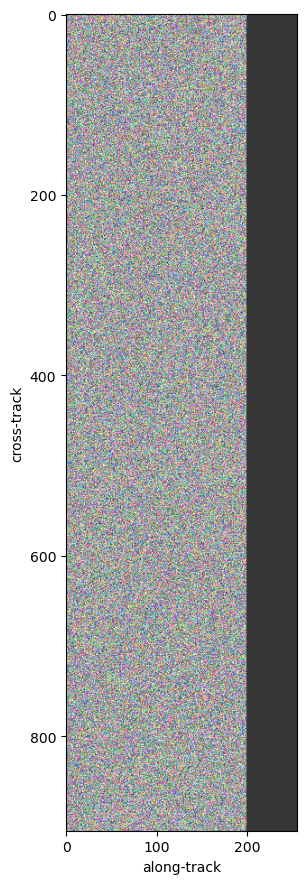

In [ ]:
#| hardware
#| eval: false
#| hide
import tempfile
import os
with tempfile.TemporaryDirectory() as temp_dir:
    dc.save(temp_dir)
    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, temp_dir)
            print(f"  {relative_path}")

In [ ]:

#| hide
import nbdev; nbdev.nbdev_export()